In [3]:
# Install required packages
!pip install librosa soundfile -q

411.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Audio processing
import librosa
import librosa.display

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-12-25 07:59:45.307289: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-25 07:59:45.323136: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-25 07:59:45.902094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-25 07:59:48.967343: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow version: 2.20.0
GPU Available: []


E0000 00:00:1766628889.856153  214484 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1766628889.859461  214484 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 2. Configuration and Setup

In [5]:
# Configuration
DATASET_PATH = '../Forest_Datasets'
SAMPLE_RATE = 22050  # Standard sample rate for audio
DURATION = 5  # 5 seconds audio clips
N_MFCC = 40  # Number of MFCCs to extract
N_MELS = 128  # Number of mel bands
HOP_LENGTH = 512
N_FFT = 2048

# Model configuration
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"Dataset path: {DATASET_PATH}")
print(f"Audio duration: {DURATION} seconds")
print(f"Sample rate: {SAMPLE_RATE} Hz")

Dataset path: ../Forest_Datasets
Audio duration: 5 seconds
Sample rate: 22050 Hz


## 3. Explore Dataset Structure

In [6]:
# Get all class folders
classes = sorted([d for d in os.listdir(DATASET_PATH) 
                  if os.path.isdir(os.path.join(DATASET_PATH, d))])

print(f"Total number of classes: {len(classes)}\n")
print("Classes:")
for i, cls in enumerate(classes, 1):
    class_path = os.path.join(DATASET_PATH, cls)
    num_files = len([f for f in os.listdir(class_path) if f.endswith(('.wav', '.mp3', '.flac'))])
    print(f"{i:2d}. {cls:20s} - {num_files} files")
    
# Identify illegal activity classes
illegal_activities = ['AXE Chopping', 'chainsaw', 'hand_saw']
print(f"\n⚠️  Illegal Activity Classes: {illegal_activities}")

Total number of classes: 25

Classes:
 1. AXE Chopping         - 79 files
 2. chainsaw             - 40 files
 3. chirping_birds       - 40 files
 4. church_bells         - 40 files
 5. cow                  - 40 files
 6. crackling_fire       - 38 files
 7. crickets             - 40 files
 8. crow                 - 40 files
 9. crying_baby          - 40 files
10. dog                  - 40 files
11. fireworks            - 40 files
12. footsteps            - 40 files
13. frog                 - 40 files
14. hand_saw             - 40 files
15. hen                  - 39 files
16. insects              - 40 files
17. pig                  - 40 files
18. pouring_water        - 40 files
19. rain                 - 40 files
20. rooster              - 40 files
21. sea_waves            - 40 files
22. sheep                - 40 files
23. thunderstorm         - 40 files
24. water_drops          - 40 files
25. wind                 - 40 files

⚠️  Illegal Activity Classes: ['AXE Chopping', 'chainsaw', 'h

## 4. Audio Feature Extraction Functions

In [7]:
def load_and_preprocess_audio(file_path, duration=DURATION, sr=SAMPLE_RATE):
    """
    Load audio file and ensure it's exactly the specified duration
    """
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, sr=sr, duration=duration)
        
        # Ensure exact duration
        target_length = sr * duration
        if len(audio) < target_length:
            # Pad if too short
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            # Trim if too long
            audio = audio[:target_length]
            
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def extract_mel_spectrogram(audio, sr=SAMPLE_RATE, n_mels=N_MELS):
    """
    Extract Mel Spectrogram features from audio
    """
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_mels=n_mels,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    )
    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def extract_mfcc(audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    """
    Extract MFCC features from audio
    """
    mfccs = librosa.feature.mfcc(
        y=audio, 
        sr=sr, 
        n_mfcc=n_mfcc,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    )
    return mfccs

def extract_features(file_path, feature_type='mel_spectrogram'):
    """
    Extract features from audio file
    feature_type: 'mel_spectrogram', 'mfcc', or 'both'
    """
    audio = load_and_preprocess_audio(file_path)
    
    if audio is None:
        return None
    
    if feature_type == 'mel_spectrogram':
        features = extract_mel_spectrogram(audio)
    elif feature_type == 'mfcc':
        features = extract_mfcc(audio)
    elif feature_type == 'both':
        mel_spec = extract_mel_spectrogram(audio)
        mfccs = extract_mfcc(audio)
        features = np.vstack([mel_spec, mfccs])
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")
    
    return features

print("✓ Feature extraction functions defined")

✓ Feature extraction functions defined


## 5. Visualize Sample Audio from Each Class

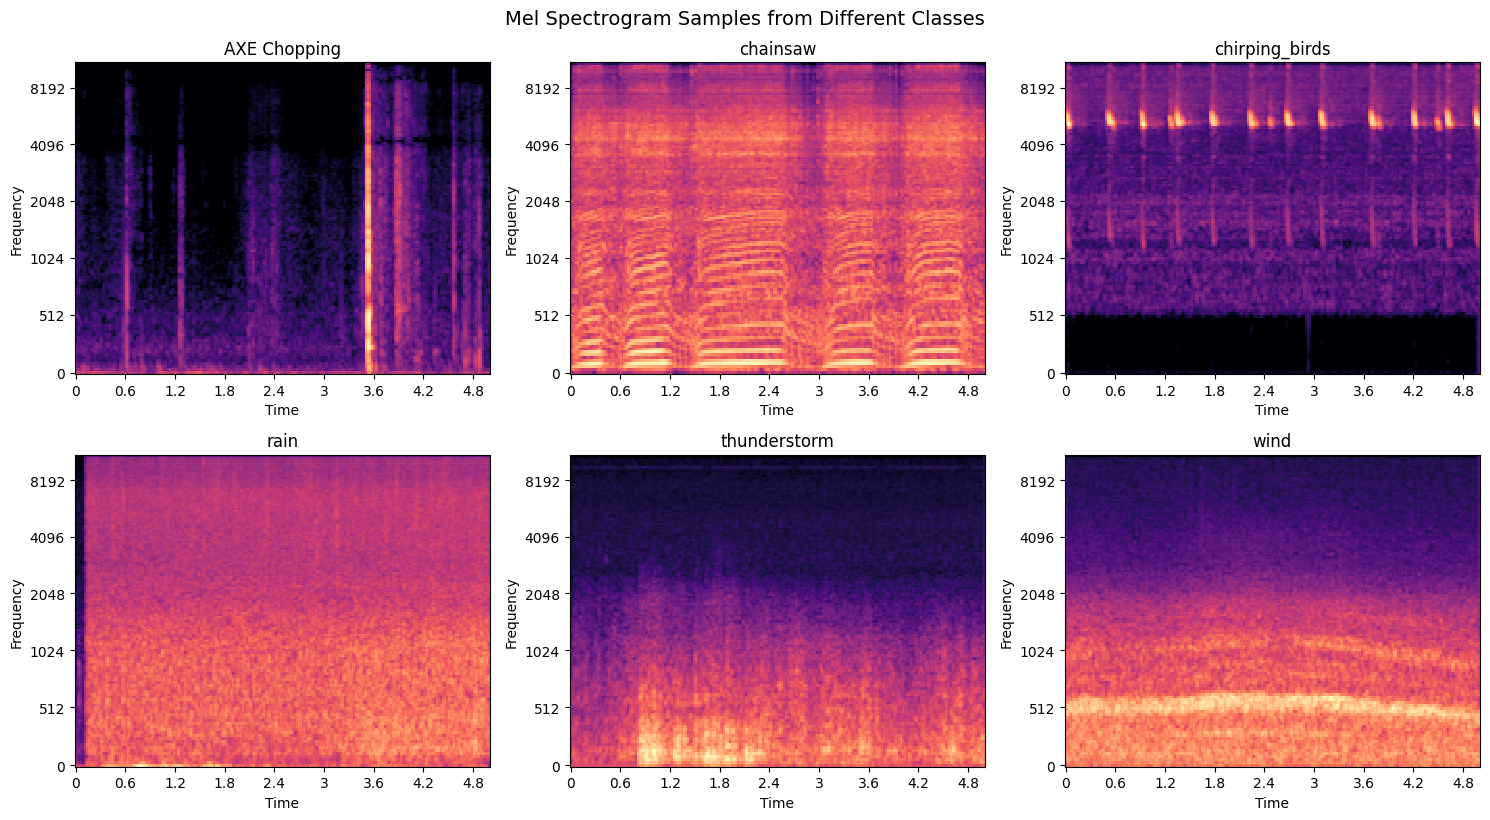

In [8]:
# Visualize sample spectrograms from different classes
sample_classes = ['AXE Chopping', 'chainsaw', 'chirping_birds', 'rain', 'thunderstorm', 'wind']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, class_name in enumerate(sample_classes):
    if idx >= len(axes):
        break
    
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_path):
        files = [f for f in os.listdir(class_path) if f.endswith(('.wav', '.mp3', '.flac'))]
        if files:
            sample_file = os.path.join(class_path, files[0])
            audio = load_and_preprocess_audio(sample_file)
            
            if audio is not None:
                mel_spec = extract_mel_spectrogram(audio)
                
                img = librosa.display.specshow(
                    mel_spec, 
                    x_axis='time', 
                    y_axis='mel',
                    sr=SAMPLE_RATE,
                    hop_length=HOP_LENGTH,
                    ax=axes[idx]
                )
                axes[idx].set_title(f'{class_name}')
                axes[idx].set_xlabel('Time')
                axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Mel Spectrogram Samples from Different Classes', y=1.02, fontsize=14)
plt.show()

## 6. Load Dataset and Extract Features

In [9]:
def load_dataset(dataset_path, feature_type='mel_spectrogram', max_samples_per_class=None):
    """
    Load all audio files and extract features
    """
    features = []
    labels = []
    file_paths = []
    
    classes = sorted([d for d in os.listdir(dataset_path) 
                     if os.path.isdir(os.path.join(dataset_path, d))])
    
    print(f"Loading dataset from {len(classes)} classes...")
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        audio_files = [f for f in os.listdir(class_path) 
                      if f.endswith(('.wav', '.mp3', '.flac', '.ogg'))]
        
        if max_samples_per_class:
            audio_files = audio_files[:max_samples_per_class]
        
        print(f"Processing {class_name}: {len(audio_files)} files...", end=' ')
        
        for audio_file in audio_files:
            file_path = os.path.join(class_path, audio_file)
            
            try:
                # Extract features
                feature = extract_features(file_path, feature_type=feature_type)
                
                if feature is not None:
                    features.append(feature)
                    labels.append(class_idx)
                    file_paths.append(file_path)
            except Exception as e:
                print(f"\nError processing {file_path}: {e}")
                continue
        
        print(f"✓ ({len([l for l in labels if l == class_idx])} loaded)")
    
    features = np.array(features)
    labels = np.array(labels)
    
    print(f"\n✓ Dataset loaded successfully!")
    print(f"  Features shape: {features.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Total samples: {len(features)}")
    
    return features, labels, classes, file_paths

# Load the dataset
print("=" * 60)
X, y, class_names, file_paths = load_dataset(DATASET_PATH, feature_type='mel_spectrogram')
print("=" * 60)

Loading dataset from 25 classes...
Processing AXE Chopping: 84 files... ✓ (84 loaded)
Processing chainsaw: 40 files... ✓ (40 loaded)
Processing chirping_birds: 40 files... ✓ (40 loaded)
Processing church_bells: 40 files... ✓ (40 loaded)
Processing cow: 40 files... ✓ (40 loaded)
Processing crackling_fire: 38 files... ✓ (38 loaded)
Processing crickets: 40 files... ✓ (40 loaded)
Processing crow: 40 files... ✓ (40 loaded)
Processing crying_baby: 40 files... ✓ (40 loaded)
Processing dog: 40 files... ✓ (40 loaded)
Processing fireworks: 40 files... ✓ (40 loaded)
Processing footsteps: 40 files... ✓ (40 loaded)
Processing frog: 40 files... ✓ (40 loaded)
Processing hand_saw: 40 files... ✓ (40 loaded)
Processing hen: 39 files... ✓ (39 loaded)
Processing insects: 40 files... ✓ (40 loaded)
Processing pig: 40 files... ✓ (40 loaded)
Processing pouring_water: 40 files... ✓ (40 loaded)
Processing rain: 40 files... ✓ (40 loaded)
Processing rooster: 40 files... ✓ (40 loaded)
Processing sea_waves: 40 file

## 7. Data Preprocessing and Splitting

In [10]:
# Add channel dimension for CNN (samples, height, width, channels)
X = X[..., np.newaxis]

print(f"Feature shape after adding channel: {X.shape}")

# Normalize features to [0, 1] range
X_min = X.min()
X_max = X.max()
X_normalized = (X - X_min) / (X_max - X_min)

print(f"Normalized features - Min: {X_normalized.min():.4f}, Max: {X_normalized.max():.4f}")

# Split dataset into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized, y, test_size=0.15, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=SEED, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

# Convert labels to one-hot encoding
num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"\nDataset split:")
print(f"  Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Number of classes: {num_classes}")

# Save normalization parameters for later use
normalization_params = {
    'min': float(X_min),
    'max': float(X_max)
}
print(f"\nNormalization parameters: {normalization_params}")

Feature shape after adding channel: (1041, 128, 216, 1)
Normalized features - Min: 0.0000, Max: 1.0000

Dataset split:
  Training set:   728 samples (69.9%)
  Validation set: 156 samples (15.0%)
  Test set:       157 samples (15.1%)
  Number of classes: 25

Normalization parameters: {'min': -80.0, 'max': 7.62939453125e-06}


## 8. Build CNN Model for Audio Classification

In [11]:
def create_cnn_model(input_shape, num_classes):
    """
    Create a CNN model for audio classification
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
input_shape = X_train.shape[1:]  # (height, width, channels)
model = create_cnn_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 216, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 108, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 54, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 27, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,948,345 (57.02 MB)

 Trainable params: 14,944,889 (57.01 MB)

 Non-trainable params: 3,456 (13.50 KB)

## 9. Setup Training Callbacks

In [12]:
# Create directory for saved models
os.makedirs('../models', exist_ok=True)

# Define callbacks
checkpoint = ModelCheckpoint(
    '../models/forest_audio_classifier_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

print("✓ Callbacks configured:")

✓ Callbacks configured:


## 10. Train the Model

In [ ]:
print("Starting training...")
print("=" * 60)

history = model.fit(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

print("=" * 60)
print("✓ Training completed!")

Starting training...
Epoch 1/100


## 11. Plot Training History

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best metrics
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f} at epoch {best_epoch + 1}")
print(f"Best Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")

## 12. Evaluate on Test Set

In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_top3_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print("=" * 60)
print("Test Set Evaluation:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Test Top-3 Accuracy: {test_top3_accuracy:.4f}")
print("=" * 60)

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

## 13. Confusion Matrix

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Forest Audio Classification', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Highlight illegal activity detection performance
print("\n⚠️  Illegal Activity Detection Performance:")
illegal_classes = ['AXE Chopping', 'chainsaw', 'hand_saw']
for illegal_class in illegal_classes:
    if illegal_class in class_names:
        idx = class_names.index(illegal_class)
        class_mask = y_test_classes == idx
        if class_mask.sum() > 0:
            class_accuracy = (y_pred_classes[class_mask] == idx).sum() / class_mask.sum()
            print(f"  {illegal_class}: {class_accuracy:.2%} accuracy ({class_mask.sum()} test samples)")

## 14. Save Final Model and Metadata

In [ ]:
import json

# Save the final model
model.save('../models/forest_audio_classifier_final.h5')
print("✓ Model saved to: ../models/forest_audio_classifier_final.h5")

# Save model metadata
metadata = {
    'model_name': 'Forest Audio Event Classifier',
    'num_classes': num_classes,
    'class_names': class_names,
    'illegal_activities': illegal_classes,
    'sample_rate': SAMPLE_RATE,
    'duration': DURATION,
    'n_mels': N_MELS,
    'n_mfcc': N_MFCC,
    'hop_length': HOP_LENGTH,
    'n_fft': N_FFT,
    'normalization': normalization_params,
    'input_shape': list(input_shape),
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test))
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✓ Metadata saved to: ../models/model_metadata.json")

# Display metadata
print("\nModel Metadata:")
print(json.dumps(metadata, indent=2))

## 15. Test Inference on Sample Audio

In [ ]:
def predict_audio_event(file_path, model, metadata):
    """
    Predict the event from an audio file
    """
    # Extract features
    features = extract_features(file_path, feature_type='mel_spectrogram')
    
    if features is None:
        return None
    
    # Normalize features
    features_normalized = (features - metadata['normalization']['min']) / \
                          (metadata['normalization']['max'] - metadata['normalization']['min'])
    
    # Add channel dimension and batch dimension
    features_normalized = features_normalized[np.newaxis, ..., np.newaxis]
    
    # Predict
    predictions = model.predict(features_normalized, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Get top 3 predictions
    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    top_3_predictions = [(metadata['class_names'][i], predictions[0][i]) for i in top_3_indices]
    
    return {
        'predicted_class': metadata['class_names'][predicted_class_idx],
        'confidence': float(confidence),
        'top_3': top_3_predictions,
        'is_illegal': metadata['class_names'][predicted_class_idx] in metadata['illegal_activities']
    }

# Test on random samples from test set
print("Testing on sample audio files:\n")
print("=" * 80)

for _ in range(5):
    # Pick a random test sample
    idx = np.random.randint(0, len(X_test))
    true_class = class_names[y_test_classes[idx]]
    
    # Get the file path for this test sample
    # Note: We'd need to map back to file paths, so let's use a different approach
    # Let's pick random files from the dataset instead
    random_class = np.random.choice(class_names)
    class_path = os.path.join(DATASET_PATH, random_class)
    audio_files = [f for f in os.listdir(class_path) if f.endswith(('.wav', '.mp3', '.flac', '.ogg'))]
    
    if audio_files:
        random_file = os.path.join(class_path, np.random.choice(audio_files))
        result = predict_audio_event(random_file, model, metadata)
        
        if result:
            print(f"File: {os.path.basename(random_file)}")
            print(f"True Class: {random_class}")
            print(f"Predicted: {result['predicted_class']} (Confidence: {result['confidence']:.2%})")
            print(f"Illegal Activity: {'⚠️  YES' if result['is_illegal'] else '✓ NO'}")
            print(f"Top 3 Predictions:")
            for i, (cls, conf) in enumerate(result['top_3'], 1):
                print(f"  {i}. {cls}: {conf:.2%}")
            print("-" * 80)

## 16. Summary and Next Steps

### Model Performance Summary
- The model is trained on 25 classes of forest audio events
- Special focus on detecting illegal activities: Axe Chopping, Chainsaw, Hand Saw
- Uses Mel Spectrogram features for audio representation
- CNN architecture with 4 convolutional blocks and dropout for regularization

### Files Created
1. `../models/forest_audio_classifier_best.h5` - Best model checkpoint
2. `../models/forest_audio_classifier_final.h5` - Final trained model
3. `../models/model_metadata.json` - Model configuration and parameters

### Next Steps for Deployment
1. **Convert model to TFLite** for edge device deployment (Arduino/ESP32)
2. **Optimize for real-time inference** on 5-second audio clips
3. **Integrate with LoRa communication** to send alerts when illegal activities detected
4. **Test in real forest environment** with various noise conditions
5. **Implement alert system** for illegal activity detection

### Usage in Real-World Application
```python
# Load model and metadata
from tensorflow import keras
import json

model = keras.models.load_model('../models/forest_audio_classifier_final.h5')
with open('../models/model_metadata.json', 'r') as f:
    metadata = json.load(f)

# Predict on new audio
result = predict_audio_event('path/to/audio.wav', model, metadata)
if result['is_illegal']:
    print(f"⚠️  ALERT: Illegal activity detected - {result['predicted_class']}")
    # Send LoRa alert with GPS coordinates
```